In [2]:
import numpy as np
# from collections import * 
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import defaultdict

In [3]:
class Env_real:
    
    def __init__(self,num_of_arms,reward_prob):
        self.num_of_arms=num_of_arms
        self.reward_prob=reward_prob

    def step(self,action):
        try:
            rwd=np.random.binomial(1,self.reward_prob[action])
        except IndexError:
            print("The arm doent exist")

        return rwd

class Env_model:
    def __init__(self,num_of_arms):
        self.num_of_arms=num_of_arms
        self.beta_param=np.ones(shape=(self.num_of_arms,2))
    
    def reset(self):
        self.beta_param=np.ones(shape=(self.num_of_arms,2))
        
    def update_env_param_step(self,action,reward):
        if reward:
            self.beta_param[action][0]+=1
        else:
            self.beta_param[action][1]+=1
        return
    def get_reward(self,action):
        alpha,beta=self.beta_param[action][0],self.beta_param[action][1]
        p=np.random.beta(alpha,beta)
        reward=np.random.binomial(1,p)        
        return reward

class Env_model_simple:
    def __init__(self,num_of_arms):
        self.num_of_arms=num_of_arms
        self.param=np.zeros(shape=(self.num_of_arms,1))
        self.counter=defaultdict(int)
    
    def reset(self):
        self.param=np.ones(shape=(self.num_of_arms,1))
        self.counter=defaultdict(int)
        
    def update_env_param_step(self,action,reward):
        self.param[action]=(self.param[action]*self.counter[action]/(self.counter[action]+1))+(reward/(self.counter[action]+1))
        return
    def get_reward(self,action):
        # alpha,beta=self.beta_param[action][0],self.beta_param[action][1]
        p=self.param[action]
        reward=np.random.binomial(1,p)        
        return reward

class Buffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def flush_all(self):
        self.buffer = []
        self.position = 0
        return

    def push(self,action, reward):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (action, reward)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        if batch_size > len(self.buffer):
            batch_size = len(self.buffer)
        batch = np.random.sample(self.buffer, int(batch_size))
        action, reward= map(np.stack, zip(*batch))
        return action, reward

class PG_Learner:
    def __init__(self,env,alpha=1,temp=1,with_prior=True):
        
        self.env=env
        if with_prior:
            self.env_model=Env_model(self.env.num_of_arms)
        else:
            self.env_model=Env_model_simple(self.env.num_of_arms)
        self.D_fake=Buffer(capacity=10000)
        
        self.params=np.ones(self.env.num_of_arms)
        
        self.alpha=alpha
        self.temp=1
        
        self.action_hist=[]
        self.reward_hist=[]
        self.P_hist=[]
        
        
        self.last_visited_Dreal=0
        self.last_visited_Dfake=0
        
   
    def Reset(self):
        
        self.params=np.ones(self.env.num_of_arms)
        self.env_model.reset()        
        self.action_hist=[]
        self.reward_hist=[]
        self.P_hist=[]
        
        return

    def get_P(self):
        
        exp = np.exp(self.params / self.temp)
        total = np.sum(exp)
        P = exp / total
        
        return P
    
    def action(self):
        # update current_action
        
        probabilities = self.get_P()
        # print(probabilities)
        action = np.random.choice(self.env.num_of_arms, 1, p=probabilities)[0]
        self.P_hist.append(probabilities)
        
        return action

    def update_param_from_step(self,action,reward):
        
        # update the param based on action and reward for a "STEP"
        

        
        # compute reward baseline by taking mean of all rewards till t-1
        
        if len(self.reward_hist) <= 1:
            reward_baseline = 0.0
        else:
            reward_baseline = np.mean(self.reward_hist[:-1])

        current_probailities = self.get_P()
        reward_baseline=0
        # update Q values for the action taken and those not taken seperately
        
        self.params[action] += (
            self.alpha * (reward - reward_baseline) * (1 - current_probailities[action])
        )
        
        ## Modified Below
        
        # self.params[action] += (
        #     self.alpha * (reward - reward_baseline) * (current_probailities[action])
        # )
        
        
        actions_not_taken = np.arange(self.env.num_of_arms) != action
        self.params[actions_not_taken] += (
            -1
            * self.alpha
            * (reward - reward_baseline)
            * current_probailities[actions_not_taken]
        )
        
        # Modified Below
        
        # actions_not_taken = np.arange(self.env.num_of_arms) != action
        # # print(actions_not_taken)
        # self.params[actions_not_taken]+=float(
        #     -1
        #     * self.alpha
        #     * (reward - reward_baseline)
        #     *self.params[actions_not_taken]*current_probailities[action]
        # )
        
        
        return 
    
    def update_param_from_buffer(self,Buffer,mult_factor=1):
        
        # Assumptions:
        
       # 1. The code will work only for the case where numb_of_interactions=1
       
        

        for i in range(self.last_visited_Dreal,Buffer.position):
            self.env_model.update_env_param_step(Buffer.buffer[i][0],Buffer.buffer[i][1])
            
        self.last_visited_Dreal=Buffer.position
        
        while self.D_fake.position!=mult_factor*Buffer.position:
            action,reward=self.Get_fakedata_step()
            self.D_fake.push(action,reward)
            
        
        # 1. Real Only 


        if self.Latest_only:
            self.reward_hist=[x[1] for x in Buffer.buffer[:-1]]
            self.action_hist=[x[0] for x in Buffer.buffer[:-1]]
            self.update_param_from_step(Buffer.buffer[-1][0],Buffer.buffer[-1][1])
            
            for i in range(1,mult_factor+1):
                self.reward_hist=[x[1] for x in self.D_fake.buffer[:-i]]
                self.action_hist=[x[0] for x in self.D_fake.buffer[:-i]]
                
                self.update_param_from_step(self.D_fake.buffer[-i][0],self.D_fake.buffer[-i][1])
                
                
                
            
            
        else:
            for tup_id in range(Buffer.position+1):
                # update 
                self.reward_hist=[x[1] for x in Buffer.buffer[:tup_id]]
                self.action_hist=[x[0] for x in Buffer.buffer[:tup_id]]
                
                self.update_param_from_step(Buffer.buffer[tup_id][0],Buffer.buffer[tup_id][1])
            
        return

    def Get_fakedata_step(self):
        action=self.action()
        alpha,beta=self.env_model.beta_param[action][0],self.env_model.beta_param[action][1]
        p=np.random.beta(alpha,beta)
        reward=np.random.binomial(1,p)        
        return action,reward

def Check_the_quality(Agent,env):
    k=100
    N=20
    
    list_of_sum=[]
    for j in range(N):
        sum_of_rwrd=0
        for i in range(k):
            action=Agent.action()
            reward=env.step(action)
            sum_of_rwrd+=reward
        list_of_sum.append(sum_of_rwrd/k)
    return np.asarray(list_of_sum).mean()


## Instantiation

In [4]:
'''

Notation followed:
    gamma=1 ---> Pure Real
    gamma=0 ---> Pure Fake

'''

'\n\nNotation followed:\n    gamma=1 ---> Pure Real\n    gamma=0 ---> Pure Fake\n\n'

In [34]:
R1_star=0.8
R2_star=0.2
gamma_list=[0,0.01,0.1,0.4,0.6]
step_size=0.1
gamma=0.1

P_star=[R1_star,R2_star]


env=Env_real(num_of_arms=2,reward_prob=P_star)
Agent=PG_Learner(env=env,alpha=step_size,with_prior=True)

In [16]:
class PlayGround:
    def __init__(self,Agent,env):
        self.Agent = Agent
        self.env=env
    def one_iter_with(self,gamma,T=10000):
        
        mode_list=[]
        param_list=[]
        Quality_list=[]
                
        self.Agent.Reset()
        # print("Before learning : ",)
        # print(Agent.params)


        for t in range(T):
            i=Agent.action()
            mode=np.random.binomial(n=1,p=(1-gamma))
            mode_list.append(mode) # For debugging
            param_list.append(Agent.params[0]) #  For debugging
            # Quality_list.append(Check_the_quality(Agent,env)) # For debugging
            Quality_list.append(None)
            if mode==0:
                r_i=np.random.binomial(n=1,p=P_star[i])
                Agent.env_model.update_env_param_step(i,r_i)
            if mode==1:
                r_i=Agent.env_model.get_reward(i)
            Agent.reward_hist.append(r_i)
            Agent.update_param_from_step(i,r_i)
            

        # print("After learning : ",)
        # print(Agent.params)
        
        return param_list,Quality_list,mode_list.count(0)
    
    def mult_iter_with(self,gamma_list,T=10000):
        
        Gamma_theta_dict=dict()
        Gamma_num_dict=dict()
        for gamma in gamma_list:
            
            # print("For Gamma = ", gamma)
            self.Agent.Reset()
            Gamma_theta_dict[gamma],_,Gamma_num_dict[gamma]=self.one_iter_with(gamma,T)
            
        return Gamma_theta_dict,Gamma_num_dict 
    
    def repeat_N_times(self,gamma_list,T=10000,N=20):
        
        Gamma_Theta_dict=dict()
        Gamma_num_dict=dict()
        
        for keys in gamma_list:
            Gamma_num_dict[keys]=[]
            Gamma_Theta_dict[keys]=[]
        
        for i in tqdm(range(N)):
            theta_dict,num_dict=self.mult_iter_with(gamma_list,T)
            for keys in gamma_list:
                Gamma_Theta_dict[keys].append(theta_dict[keys])
                Gamma_num_dict[keys].append(num_dict[keys])
        return Gamma_Theta_dict,Gamma_num_dict                
          

In [17]:
'''

Notation followed:
    gamma=1 ---> Pure Real
    gamma=0 ---> Pure Fake

'''

'\n\nNotation followed:\n    gamma=1 ---> Pure Real\n    gamma=0 ---> Pure Fake\n\n'

In [19]:
P=PlayGround(Agent,env)
Gamma_theta_dict,Gamma_num_dict=P.repeat_N_times(gamma_list=gamma_list,T=10000,N=20)

100%|██████████| 20/20 [06:56<00:00, 20.83s/it]


### Change of representation

In [20]:
Better_estimate_dict=dict()
for gamma in Gamma_theta_dict:
    Better_estimate_dict[gamma]=dict()
    
    Theta_array=np.array(Gamma_theta_dict[gamma])
    Theta_mean_array = np.mean(Theta_array, axis=0)

    std_array = np.std(Theta_array, axis=0)
    mean_plus_std_array = Theta_mean_array + std_array
    mean_minus_std_array = Theta_mean_array - std_array
    
    Better_estimate_dict[gamma]["mean"]=Theta_mean_array
    Better_estimate_dict[gamma]["upper_bound"]=mean_plus_std_array
    Better_estimate_dict[gamma]["lower_bound"]=mean_minus_std_array


In [21]:
color_palette = plt.get_cmap('tab10')

### Plotting - mean estimate

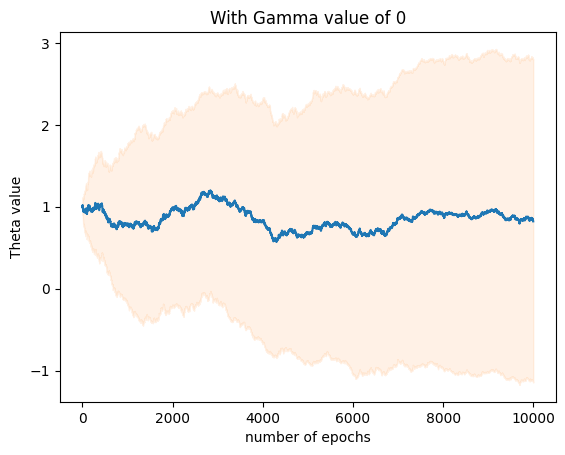

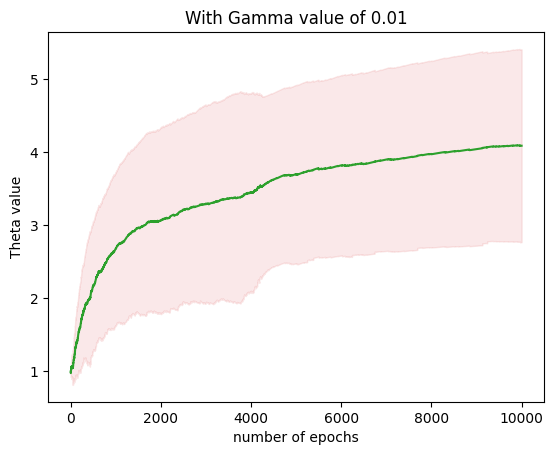

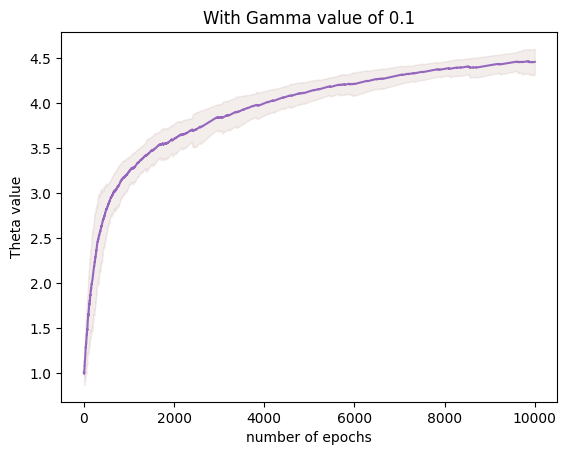

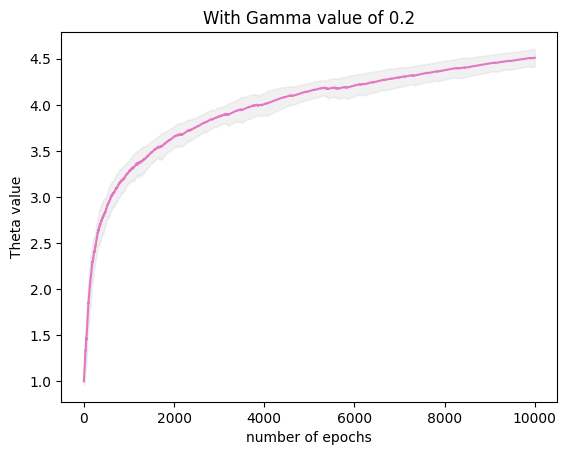

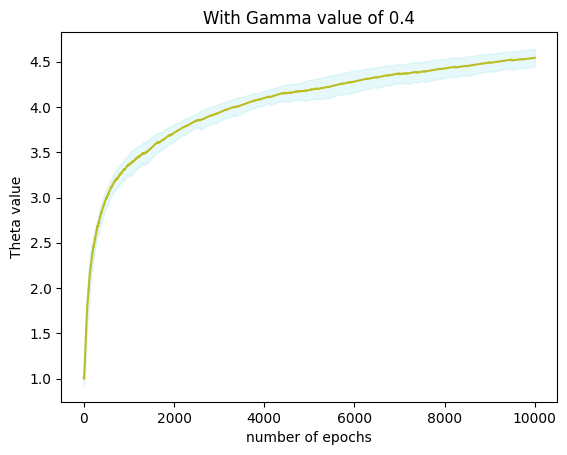

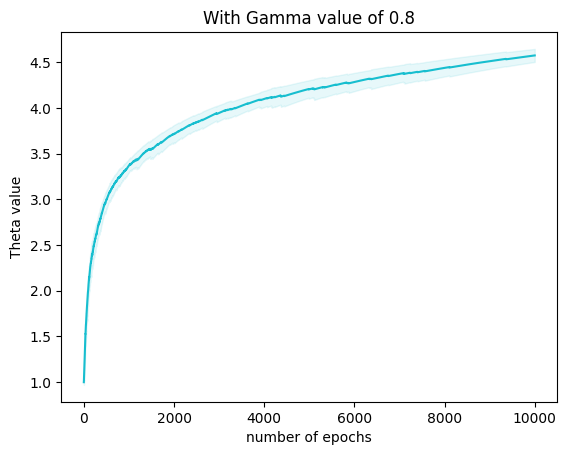

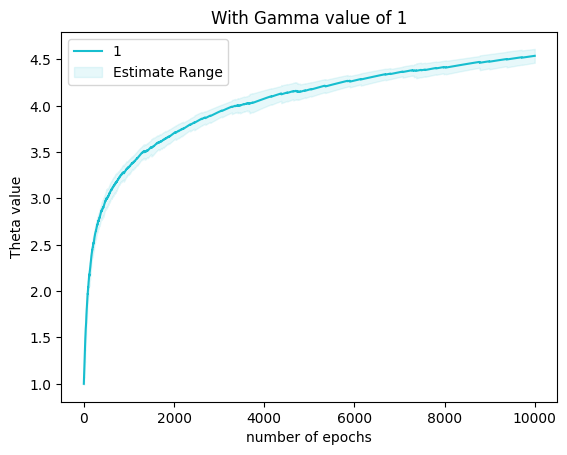

In [24]:
for i in range(len(Gamma_theta_dict.keys())):
    plt.figure()
    gamma=list(Gamma_theta_dict.keys())[i]
    x_axis=range(len(Better_estimate_dict[gamma]["mean"]))
    plt.xlabel("number of epochs")
    plt.ylabel("Theta value")
    plt.title("With Gamma value of "+str(gamma))
    plt.plot(x_axis,Better_estimate_dict[gamma]["mean"], label=str(gamma),color=color_palette(2*i))
    plt.fill_between(x_axis, Better_estimate_dict[gamma]["lower_bound"], Better_estimate_dict[gamma]["upper_bound"], alpha=0.1, label='Estimate Range', color=color_palette(2*i+1))
plt.legend()
plt.show()  

## Plotting one of the realisation

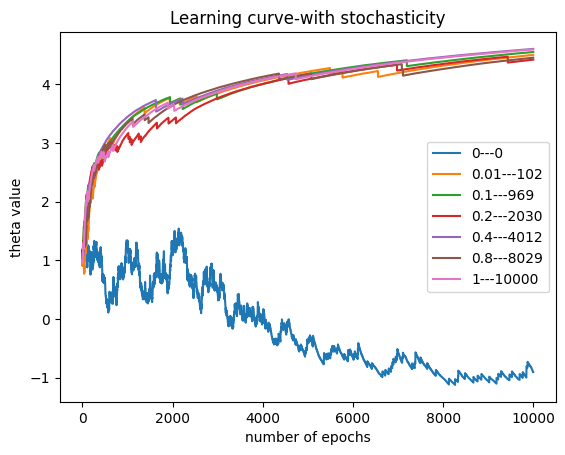

In [25]:
for gamma in Gamma_theta_dict.keys():
    plt.xlabel("number of epochs")
    plt.ylabel("theta value")
    plt.plot(Gamma_theta_dict[gamma][0],label=str(gamma)+"---"+str(Gamma_num_dict[gamma][0]))
plt.title("Learning curve-with stochasticity")
plt.legend()
plt.show()

## For gamma value of 0.01

100%|██████████| 50/50 [02:33<00:00,  3.07s/it]


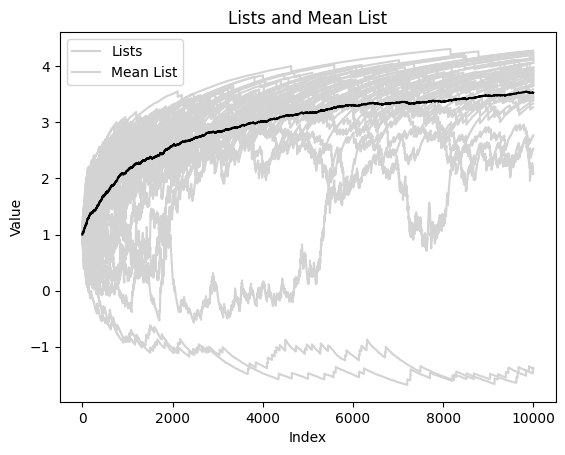

In [70]:
# gamma=0.000000001
gamma=0.2
gamma_list=[gamma]
P=PlayGround(Agent,env)
Gamma_theta_dict,Gamma_num_dict=P.repeat_N_times(gamma_list=gamma_list,T=10000,N=50)
data=Gamma_theta_dict[gamma]


# Example data
# data = [[1, 2, 3, ...], [4, 5, 6, ...], ..., [7, 8, 9, ...]]  # List with len=50, each element is a list with len=50000

# Calculate mean list
mean_list = np.mean(data, axis=0)

# Plot all lists
for sublist in data:
    plt.plot(sublist, color='lightgray')

# Plot mean list
plt.plot(mean_list, color='black')

# Customize the plot
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Lists and Mean List')
plt.legend(['Lists', 'Mean List'])

# Display the plot
plt.show()


# With Expectations- no stochasticity

In [27]:
import sympy as sp
from matplotlib import pyplot as plt

### General

In [28]:
n = sp.symbols('n', integer=True)  # Time step variable
theta = sp.symbols('theta', cls=sp.Function)
G,R1,R2,step=sp.symbols('G R1 R2 step', real=True)
P_theta=sp.exp(2*theta(n))/(sp.exp(2*theta(n)) +sp.exp(2))

## 5 Dimensional sytem

### specific to 5D formulation

In [29]:
alpha_1,beta_1,alpha_2,beta_2 = sp.symbols('alpha_1 beta_1 alpha_2 beta_2', cls=sp.Function) 

def Run_five(update_eq_list,initial_conditions,param_list,N=20):
    
    # print(gamma)
    
    
    Result={
        theta:[],
        alpha_1:[],
        beta_1:[],
        alpha_2:[],
        beta_2:[]
    }
    
    for key in initial_conditions:
        Result[key].append(initial_conditions[key])
    # print(param_list)
    for i in range(len(update_eq_list)):
        update_eq_list[i] = update_eq_list[i].subs(param_list)
    
    update_eq1,update_eq2,update_eq3,update_eq4,update_eq5=update_eq_list[0],update_eq_list[1],update_eq_list[2],update_eq_list[3],update_eq_list[4]
    # print(update_eq2)
    for t in range(N):
        
        prev=initial_conditions
        prev.update({
            theta:float(update_eq1.subs([(theta(n),initial_conditions[theta]),
                                         (alpha_1(n),initial_conditions[alpha_1]),
                                         (beta_1(n),initial_conditions[beta_1]),
                                         (alpha_2(n),initial_conditions[alpha_2]),
                                         (beta_2(n),initial_conditions[beta_2])]).evalf().rhs)})
        
        prev.update({
            alpha_1:float(update_eq2.subs([(theta(n),initial_conditions[theta]),
                                         (alpha_1(n),initial_conditions[alpha_1]),
                                         (beta_1(n),initial_conditions[beta_1]),
                                         (alpha_2(n),initial_conditions[alpha_2]),
                                         (beta_2(n),initial_conditions[beta_2])]).evalf().rhs)})
        
        prev.update({
            beta_1:float(update_eq3.subs([(theta(n),initial_conditions[theta]),
                                         (alpha_1(n),initial_conditions[alpha_1]),
                                         (beta_1(n),initial_conditions[beta_1]),
                                         (alpha_2(n),initial_conditions[alpha_2]),
                                         (beta_2(n),initial_conditions[beta_2])]).evalf().rhs)})
        prev.update({
            alpha_2:float(update_eq4.subs([(theta(n),initial_conditions[theta]),
                                         (alpha_1(n),initial_conditions[alpha_1]),
                                         (beta_1(n),initial_conditions[beta_1]),
                                         (alpha_2(n),initial_conditions[alpha_2]),
                                         (beta_2(n),initial_conditions[beta_2])]).evalf().rhs)})
        prev.update({
            beta_2:float(update_eq5.subs([(theta(n),initial_conditions[theta]),
                                         (alpha_1(n),initial_conditions[alpha_1]),
                                         (beta_1(n),initial_conditions[beta_1]),
                                         (alpha_2(n),initial_conditions[alpha_2]),
                                         (beta_2(n),initial_conditions[beta_2])]).evalf().rhs)})
        
        # print()                        
        initial_conditions=prev
        
        for key in initial_conditions:
            Result[key].append(initial_conditions[key])
        
    
    

        
        
    
    
    return Result,initial_conditions 


In [51]:
alpha_1,beta_1,alpha_2,beta_2 = sp.symbols('alpha_1 beta_1 alpha_2 beta_2', cls=sp.Function) 

def Run_five_modified(update_eq_list,initial_conditions,param_list,N=1):
    
    # print(gamma)
    
    
    Result={
        theta:[],
        alpha_1:[],
        beta_1:[],
        alpha_2:[],
        beta_2:[]
    }
    
    for key in initial_conditions:
        Result[key].append(initial_conditions[key])
    # print(param_list)
    for i in range(len(update_eq_list)):
        update_eq_list[i] = update_eq_list[i].subs(param_list)
    
    update_eq1,update_eq2,update_eq3,update_eq4,update_eq5=update_eq_list[0],update_eq_list[1],update_eq_list[2],update_eq_list[3],update_eq_list[4]
    # print(update_eq2)
    for t in tqdm(range(N)):
        
        prev=initial_conditions
        prev.update({
            theta:update_eq1.subs([(theta(n),initial_conditions[theta]),
                                         (alpha_1(n),initial_conditions[alpha_1]),
                                         (beta_1(n),initial_conditions[beta_1]),
                                         (alpha_2(n),initial_conditions[alpha_2]),
                                         (beta_2(n),initial_conditions[beta_2])]).evalf().rhs})
        
        prev.update({
            alpha_1:update_eq2.subs([(theta(n),initial_conditions[theta]),
                                         (alpha_1(n),initial_conditions[alpha_1]),
                                         (beta_1(n),initial_conditions[beta_1]),
                                         (alpha_2(n),initial_conditions[alpha_2]),
                                         (beta_2(n),initial_conditions[beta_2])]).evalf().rhs})
        
        prev.update({
            beta_1:update_eq3.subs([(theta(n),initial_conditions[theta]),
                                         (alpha_1(n),initial_conditions[alpha_1]),
                                         (beta_1(n),initial_conditions[beta_1]),
                                         (alpha_2(n),initial_conditions[alpha_2]),
                                         (beta_2(n),initial_conditions[beta_2])]).evalf().rhs})
        prev.update({
            alpha_2:update_eq4.subs([(theta(n),initial_conditions[theta]),
                                         (alpha_1(n),initial_conditions[alpha_1]),
                                         (beta_1(n),initial_conditions[beta_1]),
                                         (alpha_2(n),initial_conditions[alpha_2]),
                                         (beta_2(n),initial_conditions[beta_2])]).evalf().rhs})
        prev.update({
            beta_2:update_eq5.subs([(theta(n),initial_conditions[theta]),
                                         (alpha_1(n),initial_conditions[alpha_1]),
                                         (beta_1(n),initial_conditions[beta_1]),
                                         (alpha_2(n),initial_conditions[alpha_2]),
                                         (beta_2(n),initial_conditions[beta_2])]).evalf().rhs})
        
        # print()                        
        initial_conditions=prev
        
        for key in initial_conditions:
            Result[key].append(initial_conditions[key])
        
    
    

        
        
    
    
    return Result,initial_conditions 


### single Gamma 

In [43]:
gamma=gamma

In [ ]:


update_eq1 = sp.Eq(theta(n + 1), theta(n)+(step*(P_theta*(1-P_theta))*(G*R1+(1-G)*(alpha_1(n)/(alpha_1(n)+beta_1(n))))+(-1)*step*((1-P_theta)*P_theta)*(G*R2+(1-G)*(alpha_2(n)/(alpha_2(n)+beta_2(n))))))
update_eq2 = sp.Eq(alpha_1(n + 1), alpha_1(n)+(P_theta*G*R1))
update_eq3 = sp.Eq(beta_1(n + 1), beta_1(n)+(P_theta*G*(1-R1)))
update_eq4 = sp.Eq(alpha_2(n + 1), alpha_2(n)+((1-P_theta)*G*R2))
update_eq5 = sp.Eq(beta_2(n + 1), beta_2(n)+((1-P_theta)*G*(1-R2)))

initial_conditions = {
    theta: 1,
    alpha_1: 1,
    beta_1: 1,
    alpha_2: 1,
    beta_2: 1,
}

eq_list=[update_eq1,update_eq2,update_eq3,update_eq4,update_eq5]

Param_t,Latest=Run_five(eq_list,initial_conditions,[(R2,R2_star),(R1,R1_star),(step,step_size)],4)
theta_list=Param_t[theta]
# plt.plot(theta_list)

In [53]:
Param_t

{theta: [1, 0.0025*G + 1.0],
 alpha_1: [1,
  4.43343365935839*G*exp(0.005*G)/(7.38905609893065*exp(0.005*G) + 7.38905609893065) + 1.0],
 beta_1: [1,
  2.95562243957226*G*exp(0.005*G)/(7.38905609893065*exp(0.005*G) + 7.38905609893065) + 1.0],
 alpha_2: [1,
  0.5*G*(1.0 - 7.38905609893065*exp(0.005*G)/(7.38905609893065*exp(0.005*G) + 7.38905609893065)) + 1.0],
 beta_2: [1,
  0.5*G*(1.0 - 7.38905609893065*exp(0.005*G)/(7.38905609893065*exp(0.005*G) + 7.38905609893065)) + 1.0]}

### Multiple Gamma values

In [36]:
# gamma_list=list(np.arange(0.1,1,0.1))
gamma_list=gamma_list

In [37]:


Gamma_theta_dict = {}  # Dictionary to store results

for value in tqdm(gamma_list):
    
    update_eq1 = sp.Eq(theta(n + 1), theta(n)+(step*(P_theta*(1-P_theta))*(G*R1+(1-G)*(alpha_1(n)/(alpha_1(n)+beta_1(n))))+(-1)*step*((1-P_theta)*P_theta)*(G*R2+(1-G)*(alpha_2(n)/(alpha_2(n)+beta_2(n))))))
    update_eq2 = sp.Eq(alpha_1(n + 1), alpha_1(n)+(P_theta*G*R1))
    update_eq3 = sp.Eq(beta_1(n + 1), beta_1(n)+(P_theta*G*(1-R1)))
    update_eq4 = sp.Eq(alpha_2(n + 1), alpha_2(n)+((1-P_theta)*G*R2))
    update_eq5 = sp.Eq(beta_2(n + 1), beta_2(n)+((1-P_theta)*G*(1-R2)))
    
    eq_list=[update_eq1,update_eq2,update_eq3,update_eq4,update_eq5]

    # print(float(value))
    
    
    
    
    initial_conditions = {
    theta: 1,
    alpha_1: 1,
    beta_1: 1,
    alpha_2: 1,
    beta_2: 1,
    }
    
    Param_t,Latest=Run_five(eq_list,initial_conditions,[(R2,R2_star),(R1,R1_star),(G,float(value)),(step,step_size)],5000)
    theta_list=Param_t[theta]
    Gamma_theta_dict[value] = theta_list  # Store the result in the dictionary

 20%|██        | 1/5 [00:17<01:11, 17.95s/it]


KeyboardInterrupt: 

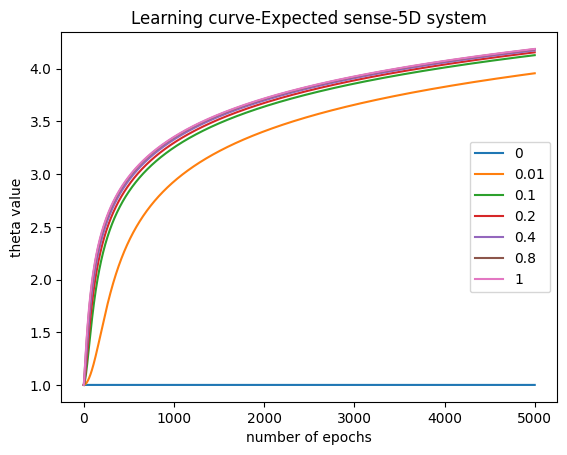

In [32]:
for gamma in Gamma_theta_dict.keys():
    plt.xlabel("number of epochs")
    plt.ylabel("theta value")
    plt.plot(Gamma_theta_dict[gamma],label=str(gamma))
plt.title("Learning curve-Expected sense-5D system")
plt.legend()
plt.show()

# 3 D System

In [38]:
N1, N2 = sp.symbols('N1 N2', cls=sp.Function)  
S1,S2=sp.symbols('S1 S2', real=True)

def Run_three(update_eq_list,initial_conditions,param_list,N=20):
    
    
    
    Result={
        theta:[],
        N1:[],
        N2:[]
    }
    
    for key in initial_conditions:
        Result[key].append(initial_conditions[key])
    
    for i in range(len(update_eq_list)):
        update_eq_list[i] = update_eq_list[i].subs(param_list)
        # print(update_eq_list[i])
    
    update_eq1,update_eq2,update_eq3=update_eq_list[0],update_eq_list[1],update_eq_list[2]
    
    for t in range(N):
        
        prev=initial_conditions
        # print(update_eq2.subs([(theta(n), initial_conditions[theta]),(N1(n),initial_conditions[N1]),(N2(n),initial_conditions[N2])]).evalf().rhs)
        prev.update({theta:float(update_eq1.subs([(theta(n), initial_conditions[theta]),(N1(n),initial_conditions[N1]),(N2(n),initial_conditions[N2])]).evalf().rhs)})
        prev.update({N1:float(update_eq2.subs([(theta(n), initial_conditions[theta]),(N1(n),initial_conditions[N1]),(N2(n),initial_conditions[N2])]).evalf().rhs)})
        prev.update({N2:float(update_eq3.subs([(theta(n), initial_conditions[theta]),(N1(n),initial_conditions[N1]),(N2(n),initial_conditions[N2])]).evalf().rhs)})
        initial_conditions=prev
        
        for key in initial_conditions:
            Result[key].append(initial_conditions[key])
        
    
    

        
        
    
    
    return Result,initial_conditions


### single gamma value

In [21]:
gamma=gamma

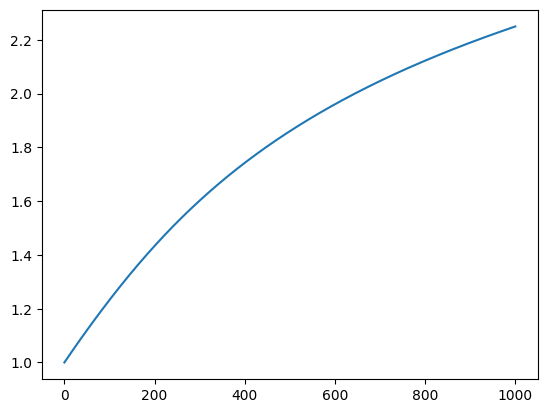

In [22]:
update_eq1 = sp.Eq(theta(n + 1), theta(n)+step*P_theta*(1-P_theta)*((R1-R2)+(1-G)*(S1*sp.sqrt(1/N1(n))-S2*sp.sqrt(1/N2(n)))))
update_eq2 = sp.Eq(N1(n + 1), N1(n)+(P_theta*G))
update_eq3 = sp.Eq(N2(n + 1),N2(n)+((1-P_theta)*G))


initial_conditions = {
    theta: 1,
    N1: 1,
    N2: 1
}

eq_list=[update_eq1,update_eq2,update_eq3]

Param_t,Latest=Run_three(eq_list,initial_conditions,[(R2,R2_star),(R1,R1_star),(G,gamma),(step,step_size),(S1,1),(S2,1)],1000)
theta_list=Param_t[theta]
plt.plot(theta_list)

### Multiple Gamma values

In [39]:
gamma_list=gamma_list

### with -ve S1

In [40]:
Gamma_theta_dict = {}  # Dictionary to store results

for value in tqdm(gamma_list):
    
    update_eq1 = sp.Eq(theta(n + 1), theta(n)+step*P_theta*(1-P_theta)*((R1-R2)+(1-G)*(S1*sp.sqrt(1/N1(n))-S2*sp.sqrt(1/N2(n)))))
    update_eq2 = sp.Eq(N1(n + 1), N1(n)+(P_theta*G))
    update_eq3 = sp.Eq(N2(n + 1),N2(n)+((1-P_theta)*G))
        
    eq_list=[update_eq1,update_eq2,update_eq3]

    # print(float(value))
    
    initial_conditions = {
    theta: 1,
    N1: 1,
    N2: 1
    }
    
    

    Param_t,Latest=Run_three(eq_list,initial_conditions,[(R2,R2_star),(R1,R1_star),(G,float(value)),(step,step_size),(S1,-1),(S2,1)],3000)
    theta_list=Param_t[theta]
    
    
    
    Gamma_theta_dict[value] = theta_list  # Store the result in the dictionary

100%|██████████| 5/5 [08:57<00:00, 107.42s/it]


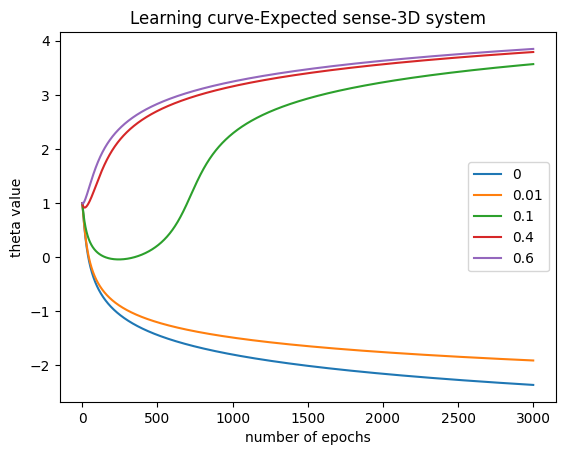

In [41]:
for gamma in Gamma_theta_dict.keys():
    plt.xlabel("number of epochs")
    plt.ylabel("theta value")
    plt.plot(Gamma_theta_dict[gamma],label=str(gamma))
plt.title("Learning curve-Expected sense-3D system")
plt.legend()
plt.show()

### with +ve S1

In [26]:
Gamma_theta_dict = {}  # Dictionary to store results

for value in tqdm(gamma_list):
    
    update_eq1 = sp.Eq(theta(n + 1), theta(n)+step*P_theta*(1-P_theta)*((R1-R2)+(1-G)*(S1*sp.sqrt(1/N1(n))-S2*sp.sqrt(1/N2(n)))))
    update_eq2 = sp.Eq(N1(n + 1), N1(n)+(P_theta*G))
    update_eq3 = sp.Eq(N2(n + 1),N2(n)+((1-P_theta)*G))
        
    eq_list=[update_eq1,update_eq2,update_eq3]

    # print(float(value))
    
    initial_conditions = {
    theta: 1,
    N1: 1,
    N2: 1
    }
    
    

    Param_t,Latest=Run_three(eq_list,initial_conditions,[(R2,R2_star),(R1,R1_star),(G,float(value)),(step,step_size),(S1,1),(S2,1)],3000)
    theta_list=Param_t[theta]
    
    
    
    Gamma_theta_dict[value] = theta_list  # Store the result in the dictionary

100%|██████████| 5/5 [08:36<00:00, 103.30s/it]


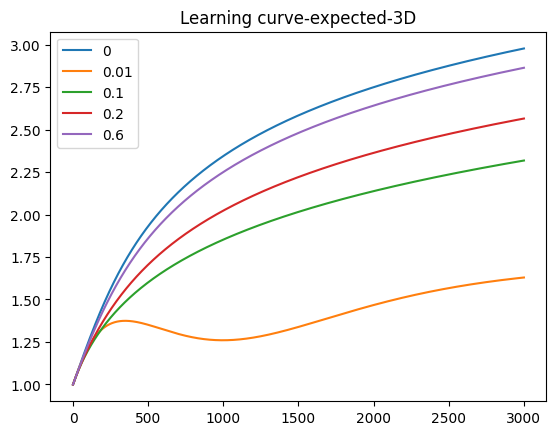

In [27]:
for gamma in Gamma_theta_dict.keys():
    plt.plot(Gamma_theta_dict[gamma],label=str(gamma))
plt.title("Learning curve-expected-3D")
plt.legend()
plt.show()

## Analytical proof

In [107]:
import sympy as sp

# Define the symbols
alpha_1_n, beta_1_n, alpha_2_n, beta_2_n, P_theta, G, R1, R2 = sp.symbols('alpha_1_n beta_1_n alpha_2_n beta_2_n P_theta G R1 R2')

# Define P_theta
# P_theta = sp.exp(2 * theta_n) / (sp.exp(2 * theta_n) + sp.exp(2))

# Define the term
term = ((alpha_1_n + (P_theta * G * R1))/(alpha_1_n + (P_theta * G * R1) + beta_1_n)) 

# Simplify the term
# simplified_term = sp.simplify(term)

# Display the simplified term
term


(G*P_theta*R1 + alpha_1_n)/(G*P_theta*R1 + alpha_1_n + beta_1_n)

In [108]:
# substituted_term = term.subs({alpha_1_n: 1, beta_1_n: 1})
substituted_term=term

# Simplify the expression
simplified_term = sp.simplify(substituted_term)
simplified_term

(G*P_theta*R1 + alpha_1_n)/(G*P_theta*R1 + alpha_1_n + beta_1_n)

In [109]:
# Differentiate the simplified expression with respect to theta
derivative_term = sp.diff(simplified_term, P_theta)

# Display the derivative expression
derivative_term=sp.simplify(derivative_term)
derivative_term

G*R1*beta_1_n/(G*P_theta*R1 + alpha_1_n + beta_1_n)**2

In [113]:
term=((alpha_2_n + ((1 - P_theta) * G * R2))/(alpha_2_n + ((1 - P_theta) * G * R2) + beta_2_n))
term

(G*R2*(1 - P_theta) + alpha_2_n)/(G*R2*(1 - P_theta) + alpha_2_n + beta_2_n)

In [114]:
# substituted_term = term.subs({alpha_2_n: 1, beta_2_n: 1})
substituted_term=term
# Simplify the expression
simplified_term = sp.simplify(substituted_term)
simplified_term

(-G*R2*(P_theta - 1) + alpha_2_n)/(-G*R2*(P_theta - 1) + alpha_2_n + beta_2_n)

In [115]:
# Differentiate the simplified expression with respect to theta
derivative_term = sp.diff(simplified_term, P_theta)

# Display the derivative expression
# derivative_term=sp.simplify(derivative_term)
derivative_term

G*R2*(-G*R2*(P_theta - 1) + alpha_2_n)/(-G*R2*(P_theta - 1) + alpha_2_n + beta_2_n)**2 - G*R2/(-G*R2*(P_theta - 1) + alpha_2_n + beta_2_n)